# DStat Testbed

In [49]:
log_path = '/home/asa/Documents/github-repos/thesis/presto/logs/profiles'
split_name = 'commonvoice-split_2021-09-25-08:51:47_0-fully-online_shards-8_threads-8_0fdb99'
#dstat_path = 'dstat_run-0_samples-12717.csv'

_shard_count = 8
_thread_count = 8
_creation_timestamp = '2021-09-25-08:51:47'
_split_name = '0-fully-online'
_shard_directory = log_path + '/' + split_name + '/'
_ueid = '0fdb99'

In [55]:
import re
import glob
import pandas as pd

def profile_as_dstat_df():
    '''Converts the logged stats via dstat while doing the profiling to a pandas DataFrame
    :return: pd.DataFrame
    '''
    dstat_filepaths = [fp for fp in glob.glob(_shard_directory + "dstat_*.csv")]
    
    def get_path_info(filepath: str):
        '''See profile.py for the definition of the destructioning pattern
        '''
        destructioning_pattern = re.compile(r"dstat_run-(?P<run>\d+)_samples-(?P<samples>\d+).csv")
        run_index, sample_count,  = destructioning_pattern.search(filepath).groups()
        return run_index, sample_count

    def prepare_columns(columns):
        '''Some magic for dstat logs
        '''
        last = None
        for (l1, l2) in columns:
            if not l1.startswith("Unnamed"):
                last = l1
            yield (last, l2)

    def load_dstats_file(csv_path: str):
        '''Loads the multi-column dstats file and adds normalized timesteps
        '''
        df = pd.read_csv(csv_path, header=[4,5])
        
        df.columns = pd.MultiIndex.from_tuples(prepare_columns(df.columns))
        
        df = df.loc[:, ~df.columns.duplicated()]

        # convert to int
        df["epoch", "epoch"] = df["epoch", "epoch"].astype(int)
        # get unique timestamps
        df_unique_epochs = df["epoch", "epoch"].drop_duplicates()
       # no way to remove duplicates in a multi-index pd frame, therefore reusing index to filter
        df = df[df.index.isin(df_unique_epochs.index.to_numpy())]
        # need to create new index now
        df.reindex(range(0, df.shape[0]))
        # add normalized time
        df["t"] = df["epoch", "epoch"]
        df["t"] -= df.t.min()
        
        return df

    dstat_dict = {
        "rel_time_s": []
       ,"disk_read_mbs": []
       ,"disk_write_mbs": []
       ,"net_read_mbs": []
       ,"net_write_mbs": []
       ,"run": []
       ,"sample_count": []
       ,"shard_count": int(_shard_count)
       ,"thread_count": int(_thread_count)
       ,"ueid": _ueid
       ,"split_name": _split_name
       ,"creation_timestamp": _creation_timestamp
       ,"cpu_usr_in_percent": []
       ,"cpu_sys_in_percent": []
       ,"cpu_idle_in_percent": []
       ,"cpu_wait_in_percent": []
       ,"system_interrupts_per_s": []
       ,"system_context_switches_per_s": []
       ,"memory_free_mb": []
       ,"memory_buffered_mb": []
       ,"memory_used_mb": []
       ,"memory_cached_mb": []
       ,"vm_major_pagefaults": []
       ,"vm_minor_pagefaults": []
       ,"vm_allocated_mb": []
       ,"vm_free_mb": []
       ,"filesystem_files": []
       ,"filesystem_inodes": []
       ,"filelocks_posix": []
       ,"filelocks_lock": []
       ,"filelocks_read": []
       ,"filelocks_write": []
    }

    for dstat_fp in dstat_filepaths:

        df = load_dstats_file(dstat_fp)

        for index, row in df.iterrows():

            rel_time_s = row["t"][0]
            disk_read_mbs  = row["dsk/total", "read"] / 1000**2
            disk_write_mbs = row["dsk/total", "writ"] / 1000**2
            net_read_mbs   = row["net/total", "recv"] / 1000**2
            net_write_mbs  = row["net/total", "send"] / 1000**2
            cpu_usr_in_percent = row["total cpu usage", "usr"]
            cpu_sys_in_percent = row["total cpu usage", "sys"]
            cpu_idle_in_percent = row["total cpu usage", "idl"]
            cpu_wait_in_percent = row["total cpu usage", "wai"]
            system_interrupts_per_s = row["system", "int"]
            system_context_switches_per_s = row["system", "csw"]
            memory_free_mb = round(row["memory usage", "free"] / 1000**2, 2)
            memory_buffered_mb = round(row["memory usage", "buff"] / 1000**2, 2)
            memory_used_mb = round(row["memory usage", "used"] / 1000**2, 2)
            memory_cached_mb = round(row["memory usage", "cach"] / 1000**2, 2)
            vm_major_pagefaults = row["virtual memory", "majpf"]
            vm_minor_pagefaults = row["virtual memory", "minpf"]
            vm_allocated_mb = round(row["virtual memory", "alloc"] / 1000**2, 2)
            vm_free_mb = round(row["virtual memory", "free"] / 1000**2, 2)
            filesystem_files = row["filesystem", "files"]
            filesystem_inodes = row["filesystem", "inodes"]
            filelocks_posix = row["file locks", "pos"]
            filelocks_lock = row["file locks", "lck"]
            filelocks_read = row["file locks", "rea"]
            filelocks_write = row["file locks", "wri"]
            
            
            run, sample_count = get_path_info(dstat_fp)
            
            dstat_dict["rel_time_s"].append(rel_time_s)
            dstat_dict["disk_read_mbs"].append(disk_read_mbs)
            dstat_dict["disk_write_mbs"].append(disk_write_mbs)
            dstat_dict["net_read_mbs"].append(net_read_mbs)
            dstat_dict["net_write_mbs"].append(net_write_mbs)
            dstat_dict["run"].append(run)
            dstat_dict["sample_count"].append(sample_count)
            dstat_dict["cpu_usr_in_percent"].append(cpu_usr_in_percent)
            dstat_dict["cpu_sys_in_percent"].append(cpu_sys_in_percent)
            dstat_dict["cpu_idle_in_percent"].append(cpu_idle_in_percent)
            dstat_dict["cpu_wait_in_percent"].append(cpu_wait_in_percent)
            dstat_dict["system_interrupts_per_s"].append(system_interrupts_per_s)
            dstat_dict["system_context_switches_per_s"].append(system_context_switches_per_s)
            dstat_dict["memory_free_mb"].append(memory_free_mb)
            dstat_dict["memory_buffered_mb"].append(memory_buffered_mb)
            dstat_dict["memory_used_mb"].append(memory_used_mb)
            dstat_dict["memory_cached_mb"].append(memory_cached_mb)
            dstat_dict["vm_major_pagefaults"].append(vm_major_pagefaults)
            dstat_dict["vm_minor_pagefaults"].append(vm_minor_pagefaults)
            dstat_dict["vm_allocated_mb"].append(vm_allocated_mb)
            dstat_dict["vm_free_mb"].append(vm_free_mb)
            dstat_dict["filesystem_files"].append(filesystem_files)
            dstat_dict["filesystem_inodes"].append(filesystem_inodes)
            dstat_dict["filelocks_posix"].append(filelocks_posix)
            dstat_dict["filelocks_lock"].append(filelocks_lock)
            dstat_dict["filelocks_read"].append(filelocks_read)
            dstat_dict["filelocks_write"].append(filelocks_write)
            

    return pd.DataFrame(dstat_dict)

In [56]:
df = profile_as_dstat_df()

In [57]:
df

,rel_time_s,disk_read_mbs,disk_write_mbs,net_read_mbs,net_write_mbs,run,sample_count,shard_count,thread_count,ueid,...,vm_major_pagefaults,vm_minor_pagefaults,vm_allocated_mb,vm_free_mb,filesystem_files,filesystem_inodes,filelocks_posix,filelocks_lock,filelocks_read,filelocks_write
0,0.0,0.078845,0.125820,0.000000,0.000000,0,12717,8,8,0fdb99,...,0.418,444.333,0.00,0.00,1504.0,13804.0,3.0,2.0,0.0,5.0
1,1.0,19.025920,0.212992,0.000755,0.000650,0,12717,8,8,0fdb99,...,89.000,5080.000,0.01,0.00,1504.0,13851.0,3.0,2.0,0.0,5.0
2,2.0,17.907712,0.094208,0.000597,0.003821,0,12717,8,8,0fdb99,...,138.000,9232.000,0.01,0.01,1504.0,13861.0,3.0,2.0,0.0,5.0
3,3.0,16.744448,0.000000,2.681244,0.030350,0,12717,8,8,0fdb99,...,139.000,6535.000,0.01,0.00,1504.0,13877.0,3.0,2.0,0.0,5.0
4,4.0,0.000000,0.000000,0.585003,0.059402,0,12717,8,8,0fdb99,...,0.000,15045.000,0.02,0.00,1504.0,13917.0,3.0,2.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,64.0,0.000000,0.000000,0.014730,0.073996,2,12717,8,8,0fdb99,...,0.000,825.000,0.00,0.00,1536.0,26945.0,3.0,2.0,0.0,5.0
609,65.0,0.000000,0.000000,0.013545,0.068671,2,12717,8,8,0fdb99,...,0.000,1970.000,0.00,0.00,1536.0,26945.0,3.0,2.0,0.0,5.0
610,66.0,0.000000,0.000000,0.017361,0.409667,2,12717,8,8,0fdb99,...,0.000,1590.000,0.00,0.00,1536.0,26945.0,3.0,2.0,0.0,5.0
611,67.0,0.000000,0.000000,0.012255,0.061687,2,12717,8,8,0fdb99,...,0.000,12309.000,0.01,0.01,1536.0,26945.0,3.0,2.0,0.0,5.0


In [61]:
import seaborn as sns
pd.set_option('display.max_rows', 200)
plotting_context = "paper"
plotting_palette = "deep"
font_scale = 1.3
sns.set(font_scale=font_scale, context=plotting_context, palette=plotting_palette)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

[Text(0.5, 0, 'Time in Seconds')]

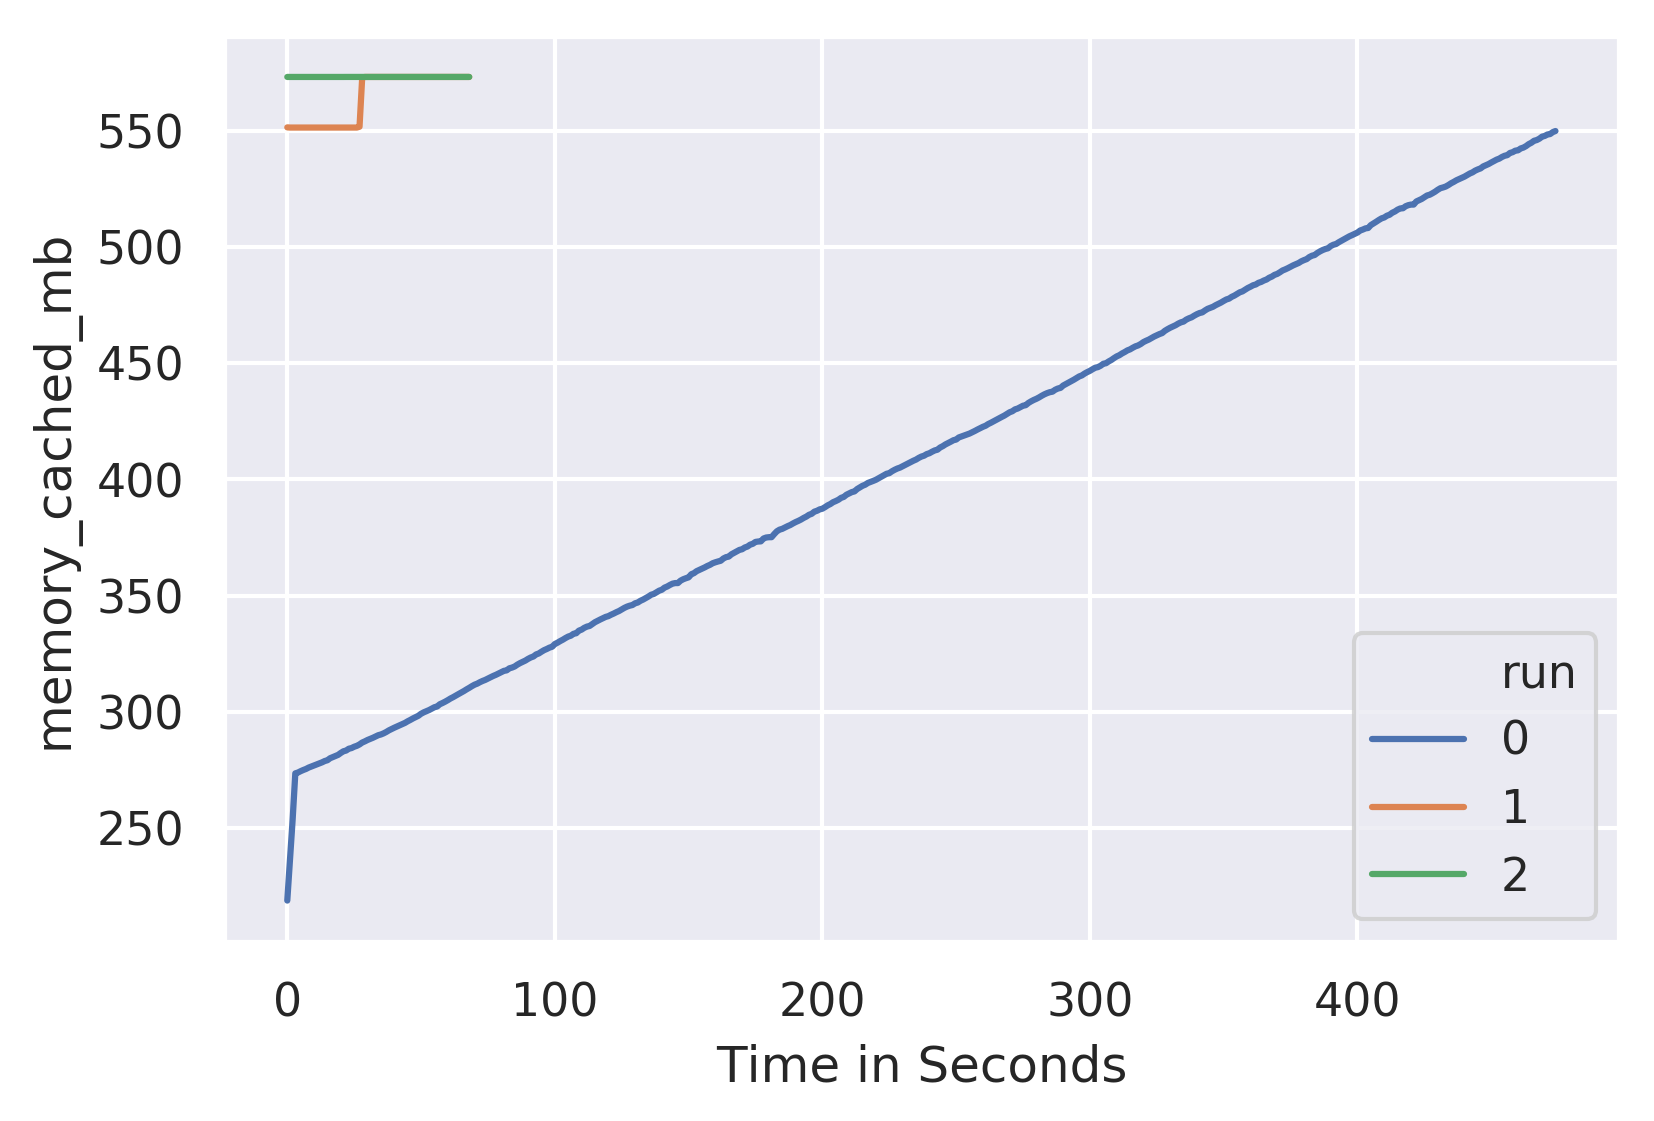

In [97]:

df["sample_count"] = df.sample_count.astype('category')
df["split_name"] = df.split_name.astype('category')
df["run"] = df.run.astype('category')
plot = sns.lineplot(
    x="rel_time_s",
    y="memory_cached_mb",
    hue="run",
    data=df,
    ci=95
)
plot.set(xlabel="Time in Seconds")#, ylabel="Network Write in MB/s")
#plot.set(ylim=(0, 1800))